<a href="https://colab.research.google.com/github/asheniagr/Asheni-s-eCornell-Portfolio/blob/main/random_forest_asheni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("saurabhbagchi/ship-and-iceberg-images")

print("Path to dataset files:", path)


100%|██████████| 404M/404M [00:05<00:00, 80.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhbagchi/ship-and-iceberg-images/versions/1


In [ ]:
import numpy as np

# 👇 replace with YOUR path from Step 2
# Add '/input_data.npz' at the end of the path
npz_path = "/root/.cache/kagglehub/datasets/saurabhbagchi/ship-and-iceberg-images/versions/1/input_data.npz"

npz = np.load(npz_path)

X_train = npz['X_train']
Y_train = npz['Y_train']
del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))


We have 4113 examples to work with


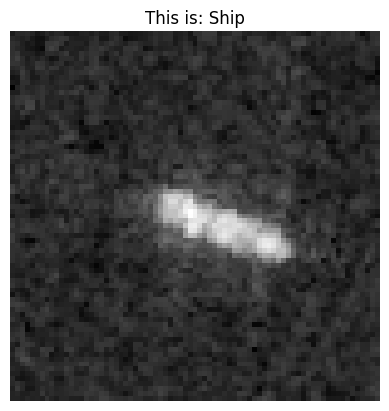

In [ ]:
# This code will display the iceberg or vessel
import matplotlib.pyplot as plt

labels=['Ship', 'Iceberg']

ix=100 # ID for specific image
plt.imshow(np.squeeze(X_train[ix, :, :, 2]), cmap='gray')
plt.title(f"This is: {labels[int(Y_train[ix])]}")
plt.axis('off')
plt.show()

In [ ]:
# Basic Dataset Information
print("=== DATASET OVERVIEW ===")
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")
print(f"Data type of images: {X_train.dtype}")
print(f"Data type of labels: {Y_train.dtype}")
print(f"Image dimensions: {X_train.shape[1]} x {X_train.shape[2]} pixels")
print(f"Number of channels: {X_train.shape[3]}")
print()

# Memory usage
print("=== MEMORY USAGE ===")
print(f"Images memory usage: {X_train.nbytes / (1024**2):.2f} MB")
print(f"Labels memory usage: {Y_train.nbytes / (1024**2):.4f} MB")
print()

# Value ranges
print("=== DATA RANGES ===")
print(f"Image pixel value range: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"Label value range: [{Y_train.min()}, {Y_train.max()}]")
print(f"Unique labels: {np.unique(Y_train)}")

=== DATASET OVERVIEW ===
Training images shape: (4113, 75, 75, 3)
Training labels shape: (4113,)
Data type of images: float64
Data type of labels: int64
Image dimensions: 75 x 75 pixels
Number of channels: 3

=== MEMORY USAGE ===
Images memory usage: 529.53 MB
Labels memory usage: 0.0314 MB

=== DATA RANGES ===
Image pixel value range: [-0.7194, 0.8484]
Label value range: [0, 1]
Unique labels: [0 1]


=== CLASS DISTRIBUTION ===
Ship (0): 2001 samples (48.7%)
Iceberg (1): 2112 samples (51.3%)


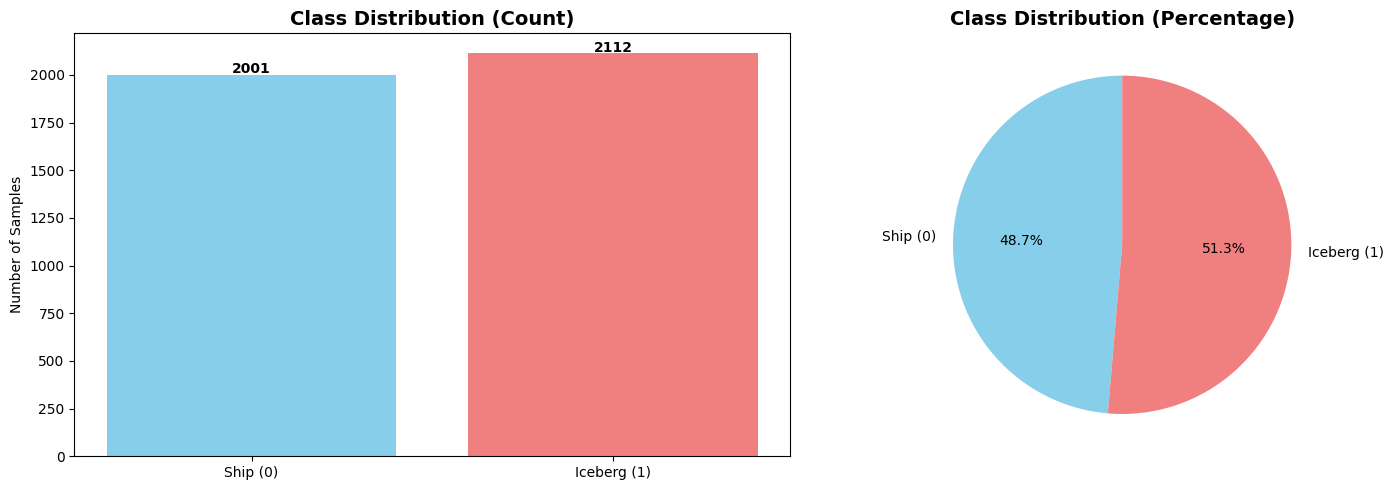


Class imbalance ratio: 1.06:1
✅ Dataset is relatively balanced


In [ ]:
# 2. Class Distribution Analysis
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count and percentage of each class
class_counts = np.bincount(Y_train.astype(int))
class_labels = ['Ship (0)', 'Iceberg (1)']
percentages = (class_counts / len(Y_train)) * 100

print("=== CLASS DISTRIBUTION ===")
for i, (label, count, pct) in enumerate(zip(class_labels, class_counts, percentages)):
    print(f"{label}: {count} samples ({pct:.1f}%)")

# Bar plot
axes[0].bar(class_labels, class_counts, color=['skyblue', 'lightcoral'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
for i, count in enumerate(class_counts):
    axes[0].text(i, count + 10, str(count), ha='center', fontweight='bold')

# Pie chart
colors = ['skyblue', 'lightcoral']
axes[1].pie(class_counts, labels=class_labels, autopct='%1.1f%%',
           colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = max(class_counts) / min(class_counts)
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("⚠️  Dataset shows class imbalance - consider balancing techniques")
else:
    print("✅ Dataset is relatively balanced")

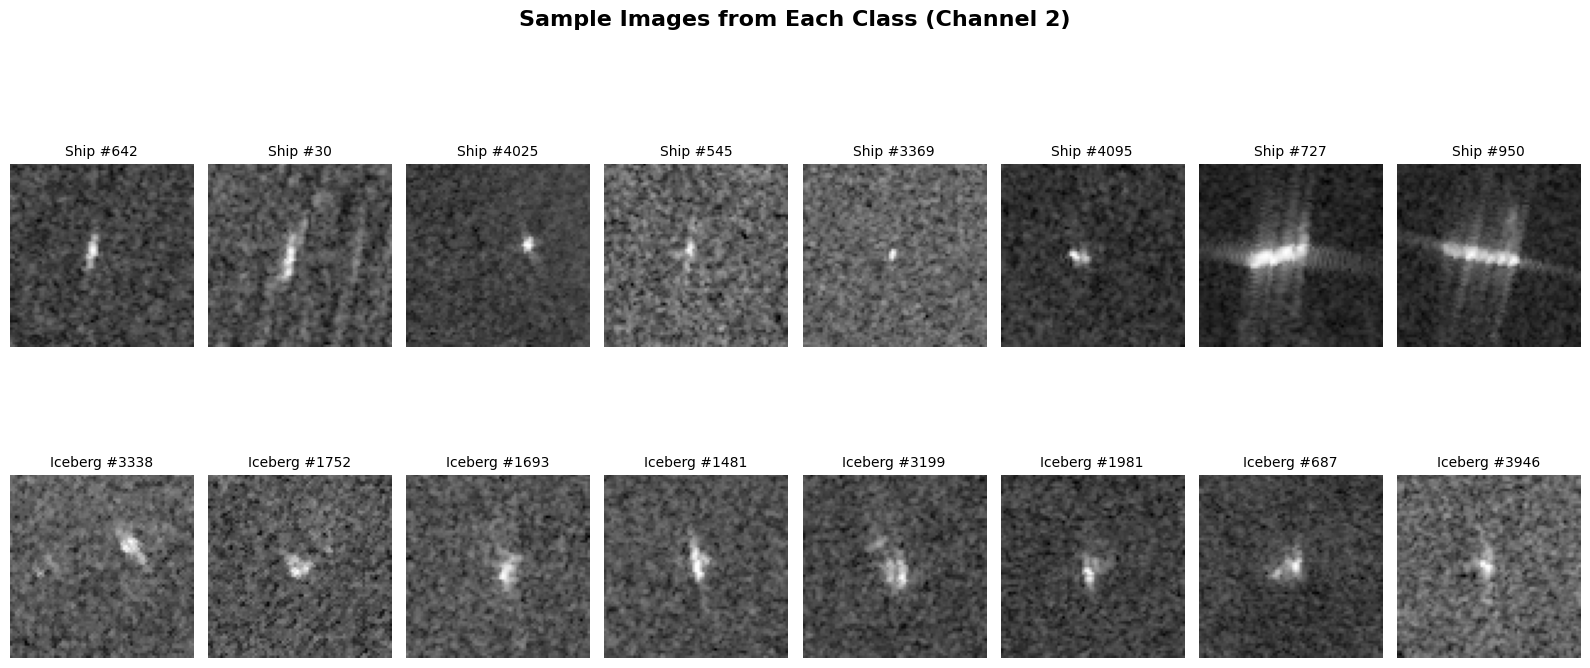

In [ ]:
# 3. Sample Images Visualization
def plot_sample_images(X, y, num_samples=8, figsize=(16, 8)):
    """
    Plot sample images for each class to visualize the differences between ships and icebergs

    Parameters:
    - X: Input images array (samples, height, width, channels)
    - y: Labels array (0 for ships, 1 for icebergs)
    - num_samples: Number of sample images to show per class
    - figsize: Figure size for the plot
    """
    # Create a subplot grid: 2 rows (one for each class) x num_samples columns
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)

    # Find all indices where labels are 0 (ships) and 1 (icebergs)
    ship_indices = np.where(y == 0)[0]        # Get all ship image indices
    iceberg_indices = np.where(y == 1)[0]     # Get all iceberg image indices

    # Randomly select sample images from each class without replacement
    # This ensures we get different examples each time we run the function
    ship_samples = np.random.choice(ship_indices, num_samples, replace=False)
    iceberg_samples = np.random.choice(iceberg_indices, num_samples, replace=False)

    # Plot ship images in the top row (row 0)
    for i, idx in enumerate(ship_samples):
        # Extract channel 2 (3rd channel) and remove single dimensions using squeeze
        # Channel 2 is often the most informative in radar imagery
        image_data = np.squeeze(X[idx, :, :, 2])

        # Display the image in grayscale colormap
        axes[0, i].imshow(image_data, cmap='gray')
        axes[0, i].set_title(f'Ship #{idx}', fontsize=10)
        axes[0, i].axis('off')  # Remove axis ticks and labels for cleaner look

    # Plot iceberg images in the bottom row (row 1)
    for i, idx in enumerate(iceberg_samples):
        # Extract channel 2 data for iceberg images
        image_data = np.squeeze(X[idx, :, :, 2])

        # Display the image in grayscale colormap
        axes[1, i].imshow(image_data, cmap='gray')
        axes[1, i].set_title(f'Iceberg #{idx}', fontsize=10)
        axes[1, i].axis('off')  # Remove axis ticks and labels for cleaner look

    # Add a main title for the entire figure
    plt.suptitle('Sample Images from Each Class (Channel 2)', fontsize=16, fontweight='bold')
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Execute the function to display random sample images from both classes
# This helps us visually understand the differences between ships and icebergs
plot_sample_images(X_train, Y_train)

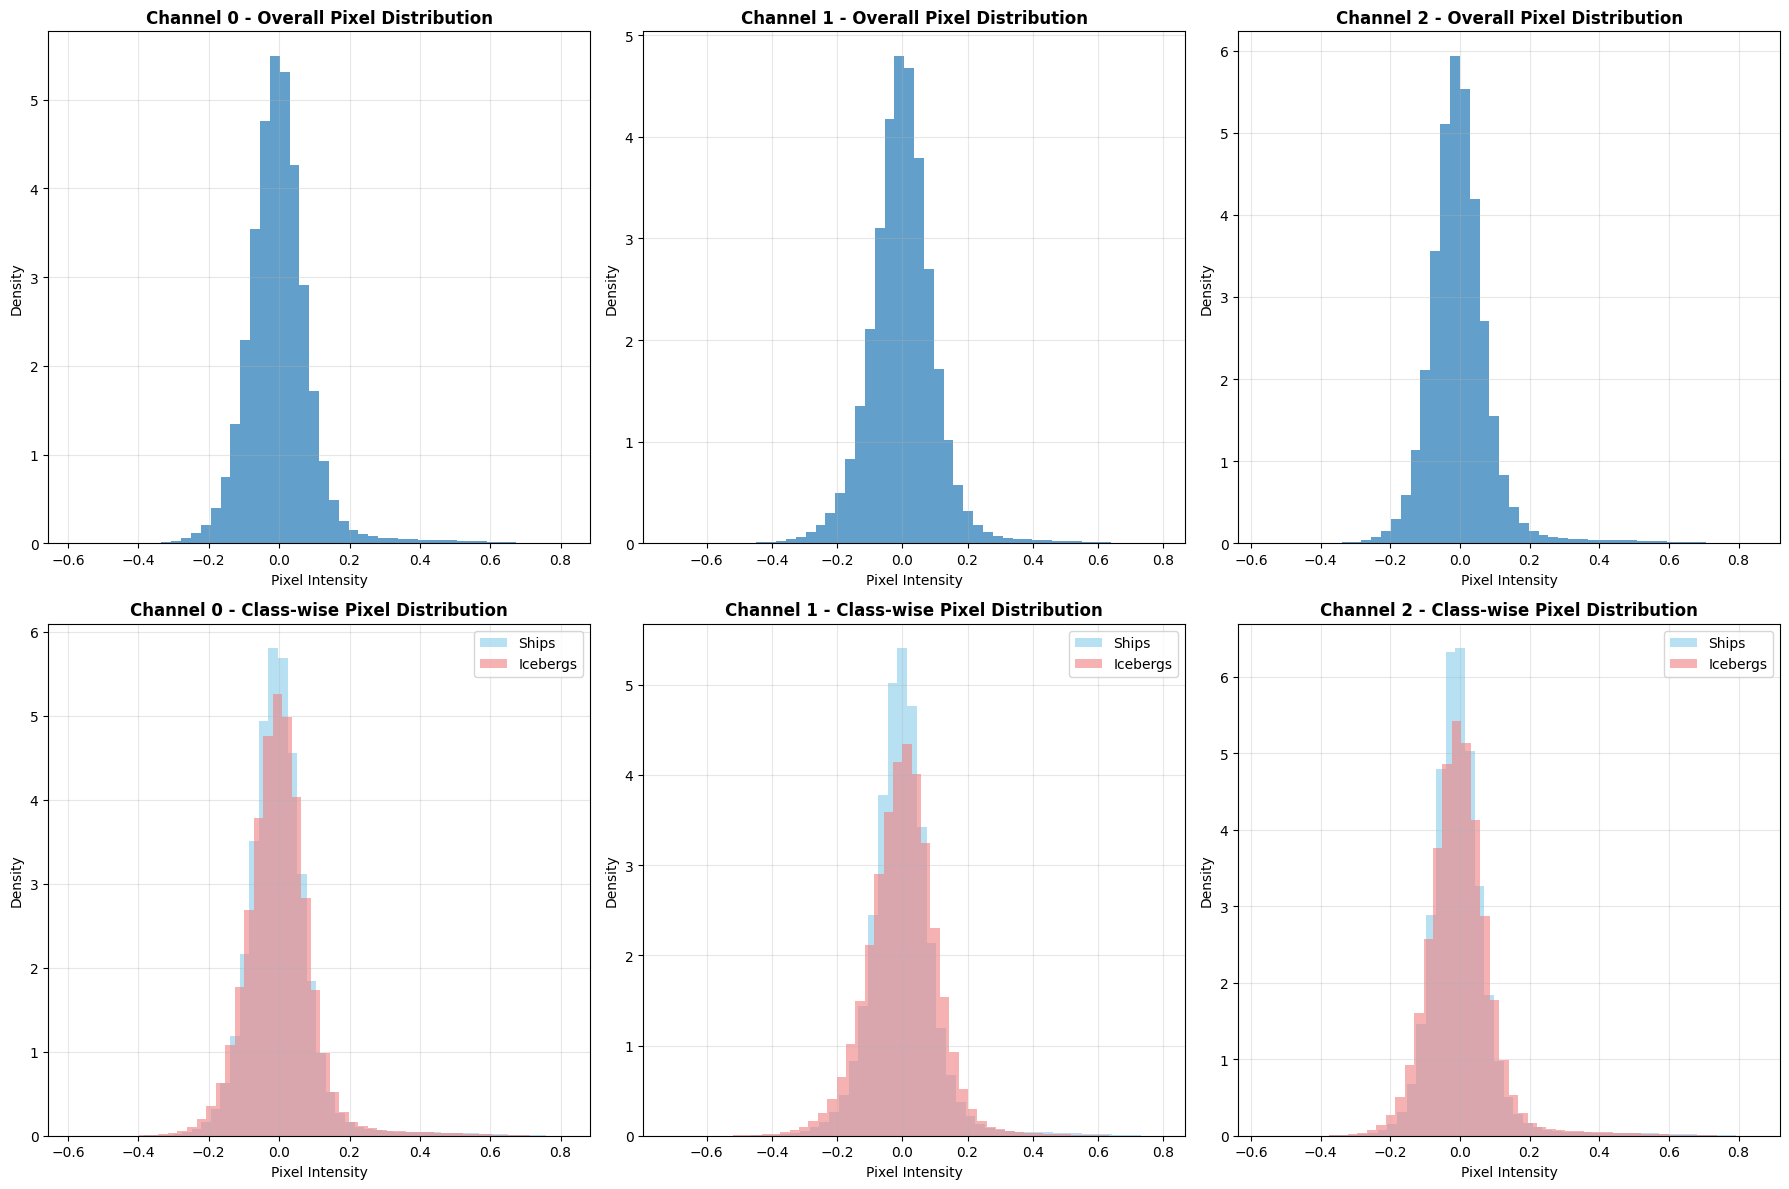

=== PIXEL INTENSITY STATISTICS BY CHANNEL ===

Channel 0:
  Mean: 0.0000
  Std:  0.0938
  Min:  -0.5865
  Max:  0.8135
  Ships - Mean: 0.0000, Std: 0.0921
  Icebergs - Mean: 0.0000, Std: 0.0955

Channel 1:
  Mean: -0.0000
  Std:  0.1024
  Min:  -0.7194
  Max:  0.7916
  Ships - Mean: -0.0000, Std: 0.0985
  Icebergs - Mean: -0.0000, Std: 0.1060

Channel 2:
  Mean: -0.0000
  Std:  0.0932
  Min:  -0.5659
  Max:  0.8484
  Ships - Mean: -0.0000, Std: 0.0912
  Icebergs - Mean: -0.0000, Std: 0.0951


In [ ]:
# 4. Pixel Intensity Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Analyze each channel
for channel in range(3):
    # Overall distribution
    axes[0, channel].hist(X_train[:, :, :, channel].flatten(), bins=50, alpha=0.7, density=True)
    axes[0, channel].set_title(f'Channel {channel} - Overall Pixel Distribution', fontweight='bold')
    axes[0, channel].set_xlabel('Pixel Intensity')
    axes[0, channel].set_ylabel('Density')
    axes[0, channel].grid(True, alpha=0.3)

    # Class-wise distribution
    ship_pixels = X_train[Y_train == 0, :, :, channel].flatten()
    iceberg_pixels = X_train[Y_train == 1, :, :, channel].flatten()

    axes[1, channel].hist(ship_pixels, bins=50, alpha=0.6, label='Ships', density=True, color='skyblue')
    axes[1, channel].hist(iceberg_pixels, bins=50, alpha=0.6, label='Icebergs', density=True, color='lightcoral')
    axes[1, channel].set_title(f'Channel {channel} - Class-wise Pixel Distribution', fontweight='bold')
    axes[1, channel].set_xlabel('Pixel Intensity')
    axes[1, channel].set_ylabel('Density')
    axes[1, channel].legend()
    axes[1, channel].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("=== PIXEL INTENSITY STATISTICS BY CHANNEL ===")
for channel in range(3):
    print(f"\nChannel {channel}:")
    print(f"  Mean: {X_train[:, :, :, channel].mean():.4f}")
    print(f"  Std:  {X_train[:, :, :, channel].std():.4f}")
    print(f"  Min:  {X_train[:, :, :, channel].min():.4f}")
    print(f"  Max:  {X_train[:, :, :, channel].max():.4f}")

    # Class-wise statistics
    ship_channel = X_train[Y_train == 0, :, :, channel]
    iceberg_channel = X_train[Y_train == 1, :, :, channel]

    print(f"  Ships - Mean: {ship_channel.mean():.4f}, Std: {ship_channel.std():.4f}")
    print(f"  Icebergs - Mean: {iceberg_channel.mean():.4f}, Std: {iceberg_channel.std():.4f}")

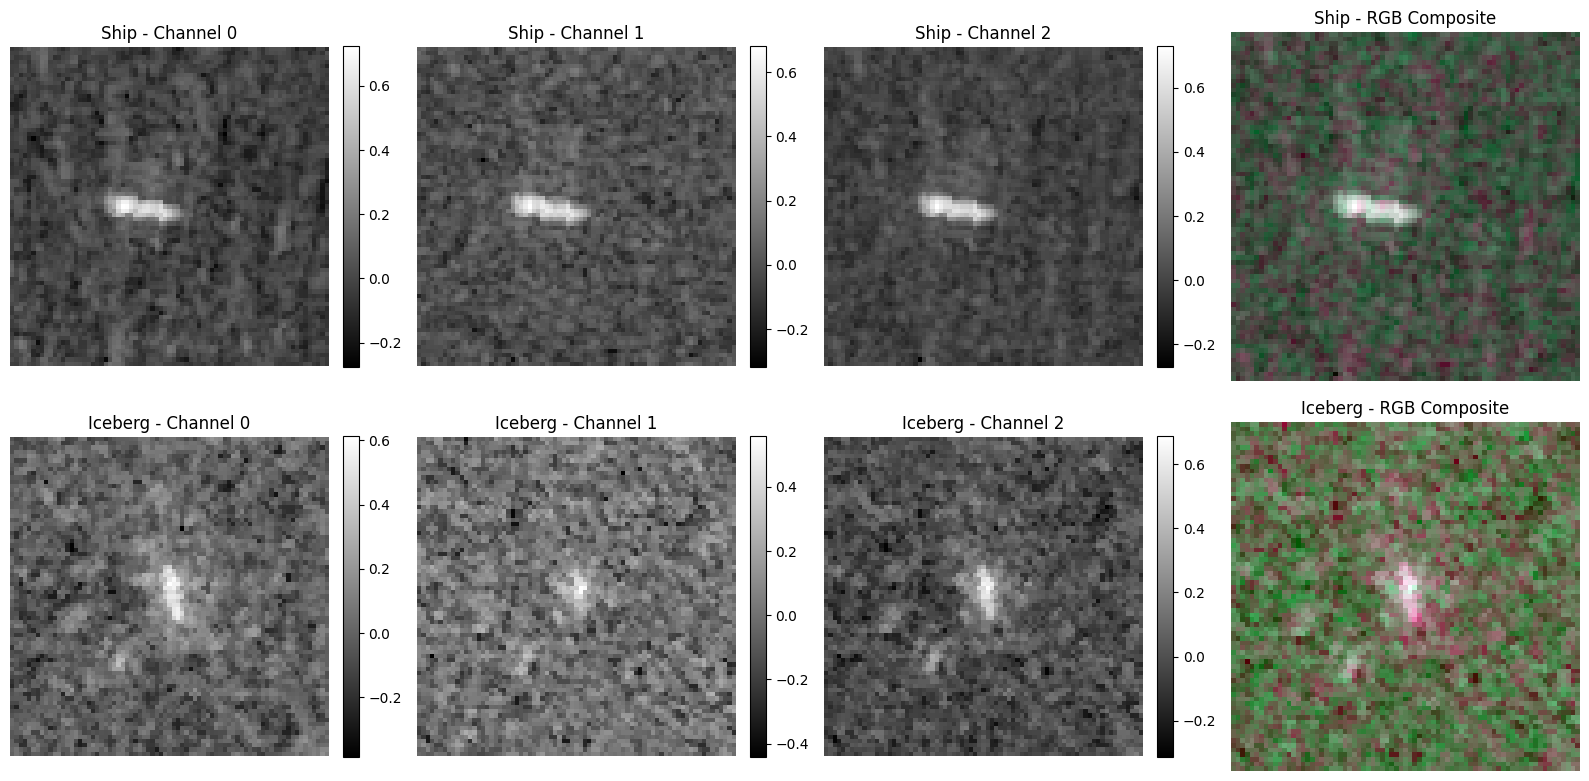

In [ ]:
# 5. Multi-Channel Image Comparison
def compare_channels(X, y, sample_idx=None):
    """Compare all three channels for sample images"""
    if sample_idx is None:
        # Select random samples from each class
        ship_idx = np.random.choice(np.where(y == 0)[0])
        iceberg_idx = np.random.choice(np.where(y == 1)[0])
        sample_indices = [ship_idx, iceberg_idx]
        class_names = ['Ship', 'Iceberg']
    else:
        sample_indices = [sample_idx]
        class_names = ['Ship' if y[sample_idx] == 0 else 'Iceberg']

    fig, axes = plt.subplots(len(sample_indices), 4, figsize=(16, 4 * len(sample_indices)))
    if len(sample_indices) == 1:
        axes = axes.reshape(1, -1)

    for row, (idx, class_name) in enumerate(zip(sample_indices, class_names)):
        # Display each channel
        for channel in range(3):
            im = axes[row, channel].imshow(np.squeeze(X[idx, :, :, channel]), cmap='gray')
            axes[row, channel].set_title(f'{class_name} - Channel {channel}')
            axes[row, channel].axis('off')
            plt.colorbar(im, ax=axes[row, channel], fraction=0.046, pad=0.04)

        # RGB composite (if applicable)
        if X.shape[3] >= 3:
            # Normalize channels for RGB display
            rgb_img = np.zeros((X.shape[1], X.shape[2], 3))
            for c in range(3):
                channel_data = X[idx, :, :, c]
                rgb_img[:, :, c] = (channel_data - channel_data.min()) / (channel_data.max() - channel_data.min())

            axes[row, 3].imshow(rgb_img)
            axes[row, 3].set_title(f'{class_name} - RGB Composite')
            axes[row, 3].axis('off')

    plt.tight_layout()
    plt.show()

compare_channels(X_train, Y_train)

Calculating image-level features...


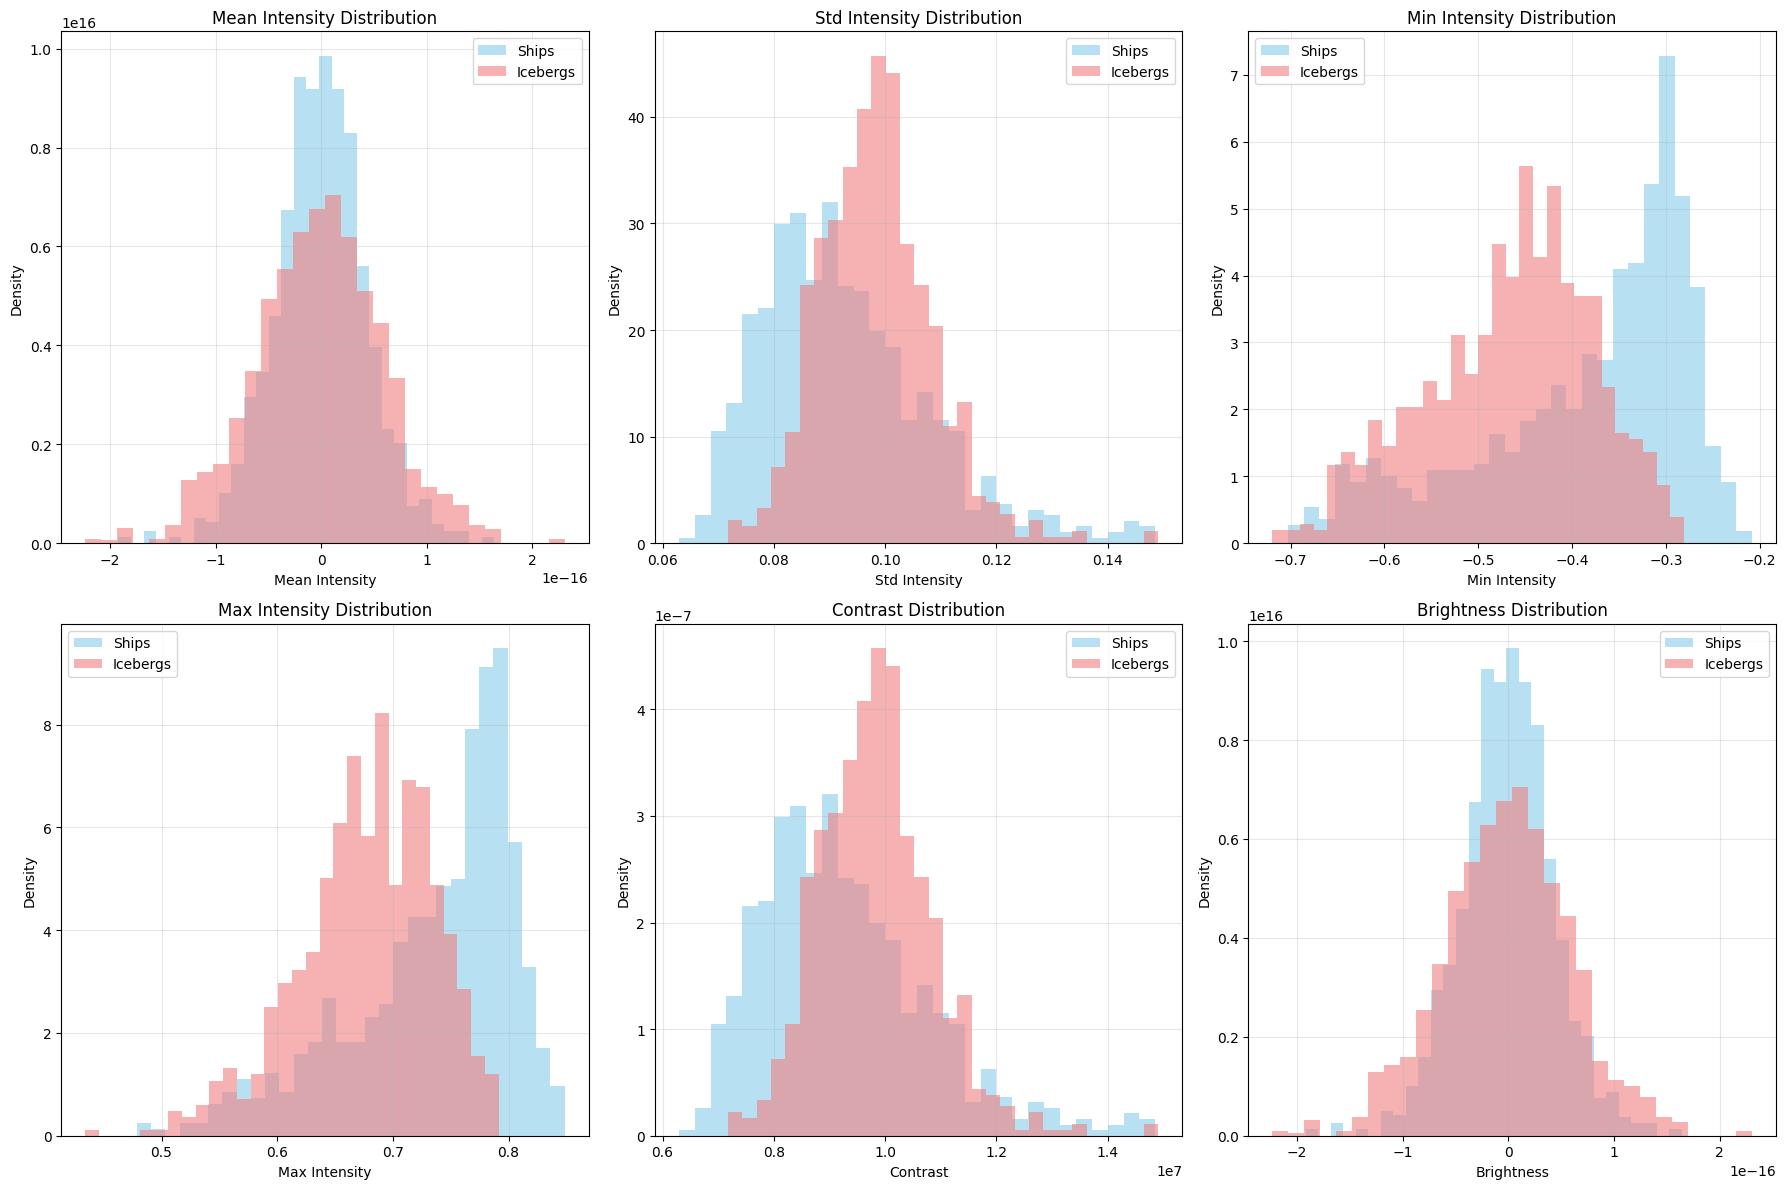


=== FEATURE COMPARISON BY CLASS ===

Mean Intensity:
  Ships     - Mean: -0.0000, Std: 0.0000
  Icebergs  - Mean: -0.0000, Std: 0.0000
  Difference: 0.0000
  T-test p-value: 0.641478 (Not significant)

Std Intensity:
  Ships     - Mean: 0.0928, Std: 0.0152
  Icebergs  - Mean: 0.0985, Std: 0.0101
  Difference: 0.0057
  T-test p-value: 0.000000 (Significant)

Min Intensity:
  Ships     - Mean: -0.3856, Std: 0.1130
  Icebergs  - Mean: -0.4674, Std: 0.0885
  Difference: 0.0818
  T-test p-value: 0.000000 (Significant)

Max Intensity:
  Ships     - Mean: 0.7349, Std: 0.0711
  Icebergs  - Mean: 0.6772, Std: 0.0579
  Difference: 0.0577
  T-test p-value: 0.000000 (Significant)

Contrast:
  Ships     - Mean: 9275287.9811, Std: 1522226.6487
  Icebergs  - Mean: 9846005.5144, Std: 1012521.5754
  Difference: 570717.5333
  T-test p-value: 0.000000 (Significant)

Brightness:
  Ships     - Mean: -0.0000, Std: 0.0000
  Icebergs  - Mean: -0.0000, Std: 0.0000
  Difference: 0.0000
  T-test p-value: 0.6414

In [ ]:
# 6. Image-level Statistics and Features
def calculate_image_features(X, y):
    """Calculate various statistical features for each image"""
    features = {
        'mean_intensity': [],
        'std_intensity': [],
        'min_intensity': [],
        'max_intensity': [],
        'contrast': [],  # std/mean
        'brightness': []  # mean across all channels
    }

    for i in range(len(X)):
        img = X[i]

        # Overall statistics
        features['mean_intensity'].append(img.mean())
        features['std_intensity'].append(img.std())
        features['min_intensity'].append(img.min())
        features['max_intensity'].append(img.max())
        features['contrast'].append(img.std() / (img.mean() + 1e-8))
        features['brightness'].append(img.mean())

    return features

# Calculate features
print("Calculating image-level features...")
features = calculate_image_features(X_train, Y_train)

# Convert to arrays for easier analysis
feature_arrays = {k: np.array(v) for k, v in features.items()}

# Plot feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_names = list(feature_arrays.keys())
for i, feature_name in enumerate(feature_names):
    ship_values = feature_arrays[feature_name][Y_train == 0]
    iceberg_values = feature_arrays[feature_name][Y_train == 1]

    axes[i].hist(ship_values, bins=30, alpha=0.6, label='Ships', density=True, color='skyblue')
    axes[i].hist(iceberg_values, bins=30, alpha=0.6, label='Icebergs', density=True, color='lightcoral')
    axes[i].set_title(f'{feature_name.replace("_", " ").title()} Distribution')
    axes[i].set_xlabel(feature_name.replace("_", " ").title())
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n=== FEATURE COMPARISON BY CLASS ===")
for feature_name in feature_names:
    ship_values = feature_arrays[feature_name][Y_train == 0]
    iceberg_values = feature_arrays[feature_name][Y_train == 1]

    print(f"\n{feature_name.replace('_', ' ').title()}:")
    print(f"  Ships     - Mean: {ship_values.mean():.4f}, Std: {ship_values.std():.4f}")
    print(f"  Icebergs  - Mean: {iceberg_values.mean():.4f}, Std: {iceberg_values.std():.4f}")
    print(f"  Difference: {abs(ship_values.mean() - iceberg_values.mean()):.4f}")

    # Simple t-test (assuming normal distribution)
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(ship_values, iceberg_values)
    print(f"  T-test p-value: {p_value:.6f} {'(Significant)' if p_value < 0.05 else '(Not significant)'}")

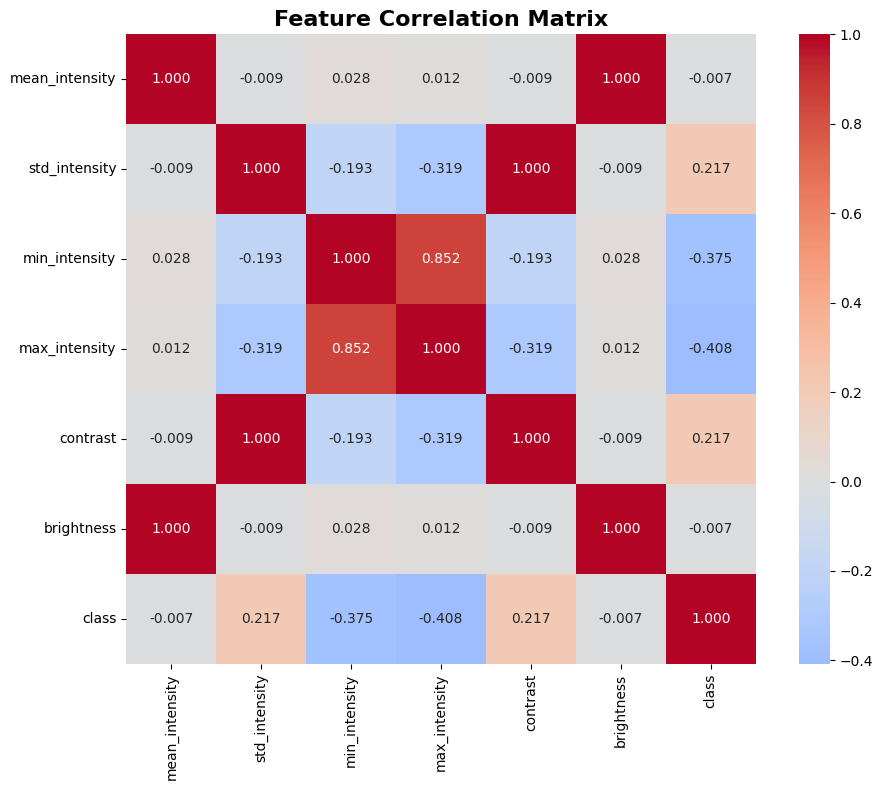

=== DATA QUALITY ANALYSIS ===
Images with NaN values: 0
Images with infinite values: 0
Labels with invalid values: 0

Checking for potential duplicates...
Unique mean values: 1 out of 4113 images
⚠️  Potential duplicates detected: 4112 images

=== OUTLIER DETECTION ===
Channel 0 outliers: 92 images (2.2%)
Channel 1 outliers: 73 images (1.8%)
Channel 2 outliers: 145 images (3.5%)


In [ ]:
# 7. Correlation Analysis and Data Quality
# Feature correlation matrix
import pandas as pd

# Create DataFrame for easier analysis
feature_df = pd.DataFrame(feature_arrays)
feature_df['class'] = Y_train

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = feature_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Data quality checks
print("=== DATA QUALITY ANALYSIS ===")

# Check for missing or invalid values
print(f"Images with NaN values: {np.isnan(X_train).any(axis=(1,2,3)).sum()}")
print(f"Images with infinite values: {np.isinf(X_train).any(axis=(1,2,3)).sum()}")
print(f"Labels with invalid values: {((Y_train != 0) & (Y_train != 1)).sum()}")

# Check for duplicate images (simplified check using mean values)
print(f"\nChecking for potential duplicates...")
image_means = X_train.mean(axis=(1,2,3))
unique_means = len(np.unique(np.round(image_means, 6)))
print(f"Unique mean values: {unique_means} out of {len(X_train)} images")
if unique_means < len(X_train):
    print(f"⚠️  Potential duplicates detected: {len(X_train) - unique_means} images")
else:
    print("✅ No obvious duplicates found")

# Channel-wise anomaly detection (simple outlier detection)
print(f"\n=== OUTLIER DETECTION ===")
for channel in range(3):
    channel_means = X_train[:, :, :, channel].mean(axis=(1,2))
    Q1 = np.percentile(channel_means, 25)
    Q3 = np.percentile(channel_means, 75)
    IQR = Q3 - Q1
    outliers = ((channel_means < Q1 - 1.5 * IQR) | (channel_means > Q3 + 1.5 * IQR)).sum()
    print(f"Channel {channel} outliers: {outliers} images ({outliers/len(X_train)*100:.1f}%)")

In [ ]:
# 8. EDA Summary and Recommendations
print("=" * 60)
print("                    EDA SUMMARY")
print("=" * 60)

print(f"""
📊 DATASET OVERVIEW:
   • Total samples: {len(X_train):,}
   • Image dimensions: {X_train.shape[1]}x{X_train.shape[2]} pixels
   • Channels: {X_train.shape[3]} (likely radar bands)
   • Classes: Ships ({(Y_train == 0).sum():,}) vs Icebergs ({(Y_train == 1).sum():,})

🎯 CLASS BALANCE:
   • Ships: {(Y_train == 0).sum()/len(Y_train)*100:.1f}%
   • Icebergs: {(Y_train == 1).sum()/len(Y_train)*100:.1f}%
   • Balance ratio: {max(np.bincount(Y_train.astype(int)))/min(np.bincount(Y_train.astype(int))):.2f}:1

📈 KEY INSIGHTS:
   • Pixel intensities range from {X_train.min():.4f} to {X_train.max():.4f}
   • Different channels show varying intensity distributions
   • Some statistical differences exist between ship and iceberg features

🔧 RECOMMENDATIONS FOR MODEL DEVELOPMENT:
""")

# Generate specific recommendations based on findings
recommendations = []

# Class balance
imbalance_ratio = max(np.bincount(Y_train.astype(int))) / min(np.bincount(Y_train.astype(int)))
if imbalance_ratio > 1.5:
    recommendations.append("   • Consider class balancing techniques (SMOTE, weighted loss, etc.)")
else:
    recommendations.append("   • ✅ Dataset is well-balanced")

# Data preprocessing
recommendations.extend([
    "   • Normalize pixel values (consider StandardScaler or MinMaxScaler)",
    "   • Apply data augmentation (rotation, flipping, noise) to increase dataset size",
    "   • Consider multi-channel feature engineering or channel selection"
])

# Model suggestions
recommendations.extend([
    "   • Try CNN architectures (ResNet, EfficientNet, VGG) for image classification",
    "   • Use transfer learning from pre-trained models",
    "   • Implement cross-validation for robust model evaluation",
    "   • Consider ensemble methods combining multiple models"
])

# Specific to radar data
recommendations.extend([
    "   • Experiment with different radar band combinations",
    "   • Apply radar-specific preprocessing if domain knowledge available",
    "   • Consider edge detection or texture analysis features"
])

for rec in recommendations:
    print(rec)

print(f"""
📋 NEXT STEPS:
   1. Data preprocessing and normalization
   2. Train/validation split with stratification
   3. Baseline model development (simple CNN)
   4. Hyperparameter tuning and model optimization
   5. Performance evaluation with multiple metrics

💡 IMPORTANT NOTES:
   • This appears to be radar/satellite imagery - domain-specific preprocessing may help
   • The 3-channel structure suggests multi-spectral or multi-polarization data
   • Consider the physical meaning of each channel for better feature engineering
""")

print("=" * 60)

                    EDA SUMMARY

📊 DATASET OVERVIEW:
   • Total samples: 4,113
   • Image dimensions: 75x75 pixels
   • Channels: 3 (likely radar bands)
   • Classes: Ships (2,001) vs Icebergs (2,112)
   
🎯 CLASS BALANCE:
   • Ships: 48.7%
   • Icebergs: 51.3%
   • Balance ratio: 1.06:1
   
📈 KEY INSIGHTS:
   • Pixel intensities range from -0.7194 to 0.8484
   • Different channels show varying intensity distributions
   • Some statistical differences exist between ship and iceberg features
   
🔧 RECOMMENDATIONS FOR MODEL DEVELOPMENT:

   • ✅ Dataset is well-balanced
   • Normalize pixel values (consider StandardScaler or MinMaxScaler)
   • Apply data augmentation (rotation, flipping, noise) to increase dataset size
   • Consider multi-channel feature engineering or channel selection
   • Try CNN architectures (ResNet, EfficientNet, VGG) for image classification
   • Use transfer learning from pre-trained models
   • Implement cross-validation for robust model evaluation
   • Consider e

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 1. Data Preparation
# Flatten the images from (num_samples, 80, 80, 3) to (num_samples, 80*80*3)
num_samples = X_train.shape[0]
X_train_flat = X_train.reshape(num_samples, -1)

# Split the data into training and testing sets
# We'll use 80% for training and 20% for testing
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_train_flat,
    Y_train,
    test_size=0.2,
    random_state=42,
    stratify=Y_train  # Ensure same class distribution in train/test
)

print("=== DATA PREPARATION COMPLETE ===")
print(f"Shape of flattened training data: {X_train_rf.shape}")
print(f"Shape of testing data: {X_test_rf.shape}")
print(f"Training labels: {y_train_rf.shape[0]}")
print(f"Testing labels: {y_test_rf.shape[0]}")

=== DATA PREPARATION COMPLETE ===
Shape of flattened training data: (3290, 16875)
Shape of testing data: (823, 16875)
Training labels: 3290
Testing labels: 823
